# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

*Описание данных:*

* children — количество детей в семье
* days_employed — общий трудовой стаж в днях
* dob_years — возраст клиента в годах
* education — уровень образования клиента
* education_id — идентификатор уровня образования
* family_status — семейное положение
* family_status_id — идентификатор семейного положения
* gender — пол клиента
* income_type — тип занятости
* debt — имел ли задолженность по возврату кредитов
* total_income — ежемесячный доход
* purpose — цель получения кредита

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [19]:
import pandas as pd
import numpy as np
from collections import Counter
from pymystem3 import Mystem

pd.set_option('display.float_format', '{:,.2f}'.format)

#Для первого запуска pymystem3 при работе в Google colab
#!wget http://download.cdn.yandex.net/mystem/mystem-3.0-linux3.1-64bit.tar.gz
#!tar -xvf mystem-3.0-linux3.1-64bit.tar.gz
#!cp mystem /root/.local/bin/mystem
#Если не в Google colab, то все закомментировать

df = pd.read_csv('https://code.s3.yandex.net/datasets/data.csv')

Просмотрим первые 15 строк

In [20]:
df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"-8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"-4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"-5,623.42",33,Среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"-4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу
5,0,-926.19,27,высшее,0,гражданский брак,1,M,компаньон,0,"255,763.57",покупка жилья
6,0,"-2,879.20",43,высшее,0,женат / замужем,0,F,компаньон,0,"240,525.97",операции с жильем
7,0,-152.78,50,СРЕДНЕЕ,1,женат / замужем,0,M,сотрудник,0,"135,823.93",образование
8,2,"-6,929.87",35,ВЫСШЕЕ,0,гражданский брак,1,F,сотрудник,0,"95,856.83",на проведение свадьбы
9,0,"-2,188.76",41,среднее,1,женат / замужем,0,M,сотрудник,0,"144,425.94",покупка жилья для семьи


Просмотрим информацию в целом

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Видим, что есть пропуски в столбцах. Прикинем в долях, сколько пропуски составляют от общего количества. (Если домножим значение на 100, то получим проценты)

In [22]:
df.isna().mean()

children           0.00
days_employed      0.10
dob_years          0.00
education          0.00
education_id       0.00
family_status      0.00
family_status_id   0.00
gender             0.00
income_type        0.00
debt               0.00
total_income       0.10
purpose            0.00
dtype: float64

Также посмотрим уникальные значения по столбцам. Для этого создадим список из интересующих нас столбцов и через цикл вызовем метод value_counts к каждому столбцу

In [23]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose'],
      dtype='object')

In [24]:
columns_to_value_counts = ['children', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt', 'purpose']

In [25]:
for c in columns_to_value_counts:
    display("---- %s ---" % c)
    display(df[c].value_counts())

'---- children ---'

 0     14149
 1      4818
 2      2055
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

'---- education ---'

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

'---- education_id ---'

1    15233
0     5260
2      744
3      282
4        6
Name: education_id, dtype: int64

'---- family_status ---'

женат / замужем          12380
гражданский брак          4177
Не женат / не замужем     2813
в разводе                 1195
вдовец / вдова             960
Name: family_status, dtype: int64

'---- family_status_id ---'

0    12380
1     4177
4     2813
3     1195
2      960
Name: family_status_id, dtype: int64

'---- gender ---'

F      14236
M       7288
XNA        1
Name: gender, dtype: int64

'---- income_type ---'

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
предприниматель        2
безработный            2
в декрете              1
студент                1
Name: income_type, dtype: int64

'---- debt ---'

0    19784
1     1741
Name: debt, dtype: int64

'---- purpose ---'

свадьба                                   797
на проведение свадьбы                     777
сыграть свадьбу                           774
операции с недвижимостью                  676
покупка коммерческой недвижимости         664
операции с жильем                         653
покупка жилья для сдачи                   653
операции с коммерческой недвижимостью     651
покупка жилья                             647
жилье                                     647
покупка жилья для семьи                   641
строительство собственной недвижимости    635
недвижимость                              634
операции со своей недвижимостью           630
строительство жилой недвижимости          626
покупка недвижимости                      624
покупка своего жилья                      620
строительство недвижимости                620
ремонт жилью                              612
покупка жилой недвижимости                607
на покупку своего автомобиля              505
заняться высшим образованием      

Также посмотрим значения с помощью метода describe()

In [26]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,"21,525.00","19,351.00","21,525.00","21,525.00","21,525.00","21,525.00","19,351.00"
mean,0.54,"63,046.50",43.29,0.82,0.97,0.08,"167,422.30"
std,1.38,"140,827.31",12.57,0.55,1.42,0.27,"102,971.57"
min,-1.00,"-18,388.95",0.00,0.00,0.00,0.00,"20,667.26"
25%,0.00,"-2,747.42",33.00,1.00,0.00,0.00,"103,053.15"
50%,0.00,"-1,203.37",42.00,1.00,0.00,0.00,"145,017.94"
75%,1.00,-291.10,53.00,1.00,1.00,0.00,"203,435.07"
max,20.00,"401,755.40",75.00,4.00,4.00,1.00,"2,265,604.03"


Интересно, что в столбце `days_employed` максимальное значение 401755.400475. В годах это 1100 лет. Так как продолжительность жизни меньше, то это значение неправильно заполнено. Попробуем найти эту строку

**Вывод**

Всего представлено 21525 строк, 12 столбцов.
Какие проблемы выявлены:
* В столбцах `days_employed` и `total_income` есть отсутствующие значения (~10% от всех данных);
* Значения в столбце `education` одинаковые, но написаны разным регистром;
* В столбце `purpose` есть одинаковые значения по смыслу;
* В столбце `days_employed` есть отрицательные значения, также тип должен быть целочисленным;
* В столбце`children` есть отрицательное значение и артефакт со значением 20;
* В столбце `gender` есть артефакт со значением XNA;
* В столбце `dob_years` есть нули



## Шаг 2. Предобработка данных

### Обработка дубликатов

В первую очередь приведем все значения в столбце `education` к нижнему регистру

In [27]:
df['education'] = df['education'].str.lower()

Проверка

In [28]:
df['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

Посмотрим, есть ли явные дубликаты

In [29]:
df.duplicated().sum()

71

Удалим такие дубликаты

In [30]:
df = df.drop_duplicates().reset_index(drop=True)

Проверка

In [31]:
df.duplicated().sum()

0

**Вывод**

Что проделано:
* значения в столбце `education` приведены к нижнему регистру;
* удалены явные дубликаты.

## Обработка артефактов, нулей и прочее

**1. Удалим строку со значением 'XNA' в столбце `gender`. Так как такая запись всего одна, то просто удалим ее.**

Узнаем текущее количество строк для последующей проверки. Так как строка, которую нужно удалить - всего одна, то длина датафрейма уменьшится на один.

In [32]:
len(df)

21454

In [33]:
df = df[df['gender'] != 'XNA']

In [34]:
len(df)

21453

Датафрейм ожидаемо уменьшился на одну строку. Проверим значения в столбце.

In [35]:
df['gender'].value_counts()

F    14174
M     7279
Name: gender, dtype: int64

сбросим индексы

In [36]:
df = df.reset_index(drop=True)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21453 entries, 0 to 21452
Data columns (total 12 columns):
children            21453 non-null int64
days_employed       19350 non-null float64
dob_years           21453 non-null int64
education           21453 non-null object
education_id        21453 non-null int64
family_status       21453 non-null object
family_status_id    21453 non-null int64
gender              21453 non-null object
income_type         21453 non-null object
debt                21453 non-null int64
total_income        19350 non-null float64
purpose             21453 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**2. Отрицательные значения в столбце `days_employed` и `children` скорее всего занесены ошибочно. Приведем их к положительным.**

In [38]:
df['days_employed'] = df['days_employed'].abs()

Проверка

In [39]:
df['days_employed'].min()

24.14163324048118

In [40]:
df['children'] = df['children'].abs()

Проверка

In [41]:
df['children'].value_counts()

0     14090
1      4855
2      2052
3       330
20       76
4        41
5         9
Name: children, dtype: int64

**3. В таблице `children` также есть значение, которое является артефактом - 20. Неизвестно, опечатка ли это при вводе 2 или 0. Так как точно установить истину в этом случае не удастся, а таких строк 76, то заполним значение по медиане значений группы `income_type`.**

Построим сводную таблицу

In [42]:
t = df.groupby(['gender', 'income_type'])['children'].agg(['count', 'sum', 'mean', 'median'])

In [43]:
t

count   sum  mean  median
gender income_type                               
F      безработный          1     0  0.00       0
       в декрете            1     2  2.00       2
       госслужащий       1072   653  0.61       0
       компаньон         3191  1810  0.57       0
       пенсионер         3132   422  0.13       0
       предприниматель      1     0  0.00       0
       сотрудник         6776  4420  0.65       0
M      безработный          1     1  1.00       1
       госслужащий        385   260  0.68       0
       компаньон         1886  1250  0.66       0
       пенсионер          697   103  0.15       0
       предприниматель      1     0  0.00       0
       сотрудник         4308  2757  0.64       0
       студент              1     0  0.00       0

Проверим суммы

In [44]:
t['count'].sum()

21453

In [45]:
len(df)

21453

суммы совпадают

Видим, что "в среднем" в данной выборке есть дети только у женщин в декрете (двое детей) и у безработных мужчин (один ребенок).
Посмотрим, у каких категорий по 20 детей

In [46]:
df[df['children'] == 20].groupby(['gender', 'income_type'])['children'].count()

gender  income_type
F       госслужащий     1
        компаньон      10
        пенсионер       8
        сотрудник      28
M       госслужащий     1
        компаньон      12
        пенсионер       1
        сотрудник      15
Name: children, dtype: int64

Среди этих категорий нет 'в декрете' и 'безработный'. Значит, все значения можно заменить на ноль

In [47]:
df['children'] = df['children'].replace(20, 0)

In [48]:
df['children'].value_counts()

0    14166
1     4855
2     2052
3      330
4       41
5        9
Name: children, dtype: int64

**4. Обработка нулей в столбце `dob_years`**

Посмотрим:
* есть ли какие-то другие сомнительные значения;
* сколько таких значений

In [49]:
df['dob_years'].unique()

array([42, 36, 33, 32, 53, 27, 43, 50, 35, 41, 40, 65, 54, 56, 26, 48, 24,
       21, 57, 67, 28, 63, 62, 47, 34, 68, 25, 31, 30, 20, 49, 37, 45, 61,
       64, 44, 52, 46, 23, 38, 39, 51,  0, 59, 29, 60, 55, 58, 71, 22, 73,
       66, 69, 19, 72, 70, 74, 75])

In [50]:
df[df['dob_years'] == 0]['dob_years'].count()

101

Таких значений всего 101. Найдем медианные значения, сгруппированные по столбцу `gender` и `income_type`, нули не учитываются.

In [51]:
t = df[df['dob_years'] != 0].groupby(['gender', 'income_type'])['dob_years'].median().reset_index()

In [52]:
t.columns

Index(['gender', 'income_type', 'dob_years'], dtype='object')

In [53]:
t.rename(columns= {'dob_years' : 'dob_years_median'}, inplace=True)

In [54]:
t.columns

Index(['gender', 'income_type', 'dob_years_median'], dtype='object')

In [55]:
t

,gender,income_type,dob_years_median
0,F,безработный,45
1,F,в декрете,39
2,F,госслужащий,41
3,F,компаньон,40
4,F,пенсионер,60
5,F,предприниматель,27
6,F,сотрудник,40
7,M,безработный,31
8,M,госслужащий,37
9,M,компаньон,38


In [56]:
df = df.merge(t, on=['gender', 'income_type'], how='left')

In [57]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_median
0,1,"8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья,40
1,1,"4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля,40
2,0,"5,623.42",33,среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья,38
3,3,"4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование,38
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21448,1,"4,529.32",43,среднее,1,гражданский брак,1,F,компаньон,0,"224,791.86",операции с жильем,40
21449,0,"343,937.40",67,среднее,1,женат / замужем,0,F,пенсионер,0,"155,999.81",сделка с автомобилем,60
21450,1,"2,113.35",38,среднее,1,гражданский брак,1,M,сотрудник,1,"89,672.56",недвижимость,38
21451,3,"3,112.48",38,среднее,1,женат / замужем,0,M,сотрудник,1,"244,093.05",на покупку своего автомобиля,38


Напишем функцию, которая на входе получает строки из df и выполняет следующее:
* Если значение равно нулю, то возвращает значение из столбца `dob_years_median`;
* В остальных случаях возвращает значение из `dob_years`

In [58]:
def replace_null_in_dob_years(row):
    if row['dob_years'] == 0:
            return row['dob_years_median']
    return row['dob_years']

Применим функцию, запишем значения в новый столбец `dob_years_no_null`

In [59]:
df['dob_years_no_null'] = df.apply(replace_null_in_dob_years, axis=1)

In [60]:
df.head(100)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,dob_years_median,dob_years_no_null
0,1,"8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья,40,42
1,1,"4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля,40,36
2,0,"5,623.42",33,среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья,38,33
3,3,"4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование,38,32
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу,60,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,541.83,51,высшее,0,женат / замужем,0,F,сотрудник,0,"94,187.88",автомобиль,40,51
96,0,nan,44,среднее,1,женат / замужем,0,F,сотрудник,0,nan,покупка жилой недвижимости,40,44
97,0,nan,47,высшее,0,женат / замужем,0,F,сотрудник,0,nan,профильное образование,40,47
98,0,"364,906.21",54,высшее,0,женат / замужем,0,F,пенсионер,0,"199,707.30",покупка жилья для сдачи,60,54


Проверим. Если все верно, то медианные значения в этих столбцах должны быть равны

In [61]:
df[df['dob_years'] != 0].groupby(['gender', 'income_type'])['dob_years'].median().reset_index()

,gender,income_type,dob_years
0,F,безработный,45
1,F,в декрете,39
2,F,госслужащий,41
3,F,компаньон,40
4,F,пенсионер,60
5,F,предприниматель,27
6,F,сотрудник,40
7,M,безработный,31
8,M,госслужащий,37
9,M,компаньон,38


In [62]:
df.groupby(['gender', 'income_type'])['dob_years_no_null'].median().reset_index()

,gender,income_type,dob_years_no_null
0,F,безработный,45
1,F,в декрете,39
2,F,госслужащий,41
3,F,компаньон,40
4,F,пенсионер,60
5,F,предприниматель,27
6,F,сотрудник,40
7,M,безработный,31
8,M,госслужащий,37
9,M,компаньон,38


In [63]:
sorted(df['dob_years_no_null'].unique())

[19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75]

Как видим, в новом столбце нет нулей, и они заполнены медианными значениями. Теперь заменим значения столбца `dob_years` на значения из `dob_years_no_null`, последний столбец и столбец с медианными значениями удалим.

In [64]:
df['dob_years'] = df['dob_years_no_null']

In [65]:
df.drop(['dob_years_no_null', 'dob_years_median'], axis=1, inplace=True)

In [66]:
df.head(15)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"5,623.42",33,среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу
5,0,926.19,27,высшее,0,гражданский брак,1,M,компаньон,0,"255,763.57",покупка жилья
6,0,"2,879.20",43,высшее,0,женат / замужем,0,F,компаньон,0,"240,525.97",операции с жильем
7,0,152.78,50,среднее,1,женат / замужем,0,M,сотрудник,0,"135,823.93",образование
8,2,"6,929.87",35,высшее,0,гражданский брак,1,F,сотрудник,0,"95,856.83",на проведение свадьбы
9,0,"2,188.76",41,среднее,1,женат / замужем,0,M,сотрудник,0,"144,425.94",покупка жилья для семьи


### Обработка пропусков

Так как пропущенные значения составляют более 10% от всех данных, то удалить такие строки не можем. Заполним медианным значением, сгруппировав значения по `gender` и `income_type`

Начнем со значений в `days_employed`

In [67]:
df.groupby(['gender', 'income_type'])['days_employed'].agg(['count', 'median']).reset_index()

,gender,income_type,count,median
0,F,безработный,1,"395,302.84"
1,F,в декрете,1,"3,296.76"
2,F,госслужащий,962,"2,705.84"
3,F,компаньон,2870,"1,584.34"
4,F,пенсионер,2806,"366,182.93"
5,F,предприниматель,1,520.85
6,F,сотрудник,6111,"1,718.51"
7,M,безработный,1,"337,524.47"
8,M,госслужащий,350,"2,659.33"
9,M,компаньон,1706,"1,472.89"


Видим, что в группах есть единичные значения, а также пропущенное значение для мужчины предпринимателя.
Посмотрим, в каких группах пропуски, количество пропусков.

In [68]:
df.groupby(['gender', 'income_type'])['days_employed'].apply(lambda x: x.isnull().sum()).reset_index()

,gender,income_type,days_employed
0,F,безработный,0
1,F,в декрете,0
2,F,госслужащий,110
3,F,компаньон,321
4,F,пенсионер,326
5,F,предприниматель,0
6,F,сотрудник,665
7,M,безработный,0
8,M,госслужащий,35
9,M,компаньон,180


Значение для предпринимателя-мужчины пропущено. Так как это единственная строка, то ее следует удалить. Остальные пропущенные значения в группах заполним медианным значением.

In [69]:
len(df)

21453

In [70]:
df = df[(df['gender'] != 'M') | (df['income_type'] != 'предприниматель')]

In [71]:
len(df)

21452

In [72]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21452 entries, 0 to 21452
Data columns (total 12 columns):
children            21452 non-null int64
days_employed       19350 non-null float64
dob_years           21452 non-null int64
education           21452 non-null object
education_id        21452 non-null int64
family_status       21452 non-null object
family_status_id    21452 non-null int64
gender              21452 non-null object
income_type         21452 non-null object
debt                21452 non-null int64
total_income        19350 non-null float64
purpose             21452 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.1+ MB


In [73]:
df.reset_index(drop=True, inplace=True)

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21452 entries, 0 to 21451
Data columns (total 12 columns):
children            21452 non-null int64
days_employed       19350 non-null float64
dob_years           21452 non-null int64
education           21452 non-null object
education_id        21452 non-null int64
family_status       21452 non-null object
family_status_id    21452 non-null int64
gender              21452 non-null object
income_type         21452 non-null object
debt                21452 non-null int64
total_income        19350 non-null float64
purpose             21452 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Количество записей ожидаемо уменьшилось на 1. Все верно

Заполним пропуски медианным значением

In [75]:
df['days_employed'] = df.groupby(['gender', 'income_type'])['days_employed'].transform(lambda x: x.fillna(x.median()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21452 entries, 0 to 21451
Data columns (total 12 columns):
children            21452 non-null int64
days_employed       21452 non-null float64
dob_years           21452 non-null int64
education           21452 non-null object
education_id        21452 non-null int64
family_status       21452 non-null object
family_status_id    21452 non-null int64
gender              21452 non-null object
income_type         21452 non-null object
debt                21452 non-null int64
total_income        19350 non-null float64
purpose             21452 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [77]:
df['total_income'] = df.groupby(['gender', 'income_type'])['total_income'].transform(lambda x: x.fillna(x.median()))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [78]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21452 entries, 0 to 21451
Data columns (total 12 columns):
children            21452 non-null int64
days_employed       21452 non-null float64
dob_years           21452 non-null int64
education           21452 non-null object
education_id        21452 non-null int64
family_status       21452 non-null object
family_status_id    21452 non-null int64
gender              21452 non-null object
income_type         21452 non-null object
debt                21452 non-null int64
total_income        21452 non-null float64
purpose             21452 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


Значения заполнены, для проверки сформируем снова сводную таблицу

In [79]:
df.groupby(['gender', 'income_type'])['days_employed'].agg(['count', 'median']).reset_index()

,gender,income_type,count,median
0,F,безработный,1,"395,302.84"
1,F,в декрете,1,"3,296.76"
2,F,госслужащий,1072,"2,705.84"
3,F,компаньон,3191,"1,584.34"
4,F,пенсионер,3132,"366,182.93"
5,F,предприниматель,1,520.85
6,F,сотрудник,6776,"1,718.51"
7,M,безработный,1,"337,524.47"
8,M,госслужащий,385,"2,659.33"
9,M,компаньон,1886,"1,472.89"


**Вывод**

Значительная часть данных в двух столбцах была пропущена. В этом случае мы заполнили такие данные медианным значением по полу и статусу, а единственное значение, которое содержит пропущенное значени - удалили.

### Замена типа данных

In [80]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"8,437.67",42,высшее,0,женат / замужем,0,F,сотрудник,0,"253,875.64",покупка жилья
1,1,"4,024.80",36,среднее,1,женат / замужем,0,F,сотрудник,0,"112,080.01",приобретение автомобиля
2,0,"5,623.42",33,среднее,1,женат / замужем,0,M,сотрудник,0,"145,885.95",покупка жилья
3,3,"4,124.75",32,среднее,1,женат / замужем,0,M,сотрудник,0,"267,628.55",дополнительное образование
4,0,"340,266.07",53,среднее,1,гражданский брак,1,F,пенсионер,0,"158,616.08",сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21447,1,"4,529.32",43,среднее,1,гражданский брак,1,F,компаньон,0,"224,791.86",операции с жильем
21448,0,"343,937.40",67,среднее,1,женат / замужем,0,F,пенсионер,0,"155,999.81",сделка с автомобилем
21449,1,"2,113.35",38,среднее,1,гражданский брак,1,M,сотрудник,1,"89,672.56",недвижимость
21450,3,"3,112.48",38,среднее,1,женат / замужем,0,M,сотрудник,1,"244,093.05",на покупку своего автомобиля


Видим, что значения дней стажа и заработка дробные. Исправим это, отбросив дробную часть.

In [81]:
df['days_employed'] = df['days_employed'].astype('int')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [82]:
df['total_income'] = df['total_income'].astype('int')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21447,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем
21448,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем
21449,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость
21450,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля


В столбце стажа есть значения, которые значительно превышают возраст. Скорее всего ошибочно были занесены часы в место дней. Чтобы это выяснить, добавим новый столбец, где дни стажа переведем в года, а затем в другой столбец запишем разницу между возрастом и стажем.

In [84]:
df['years_employed'] = df['days_employed'] / 365

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [85]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23.12
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11.02
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15.41
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11.30
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,932.24
...,...,...,...,...,...,...,...,...,...,...,...,...,...
21447,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,12.41
21448,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,942.29
21449,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,5.79
21450,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,8.53


In [86]:
df['diff_dob_employed'] = df['dob_years'] - df['years_employed']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [87]:
df['diff_dob_employed'].min()

-1057.150684931507

In [88]:
df[df['diff_dob_employed'] < 0]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,diff_dob_employed
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,932.24,-879.24
12,0,361781,65,среднее,1,гражданский брак,1,M,пенсионер,0,130739,сыграть свадьбу,991.18,-926.18
18,0,400281,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823,на покупку подержанного автомобиля,"1,096.66","-1,043.66"
24,1,338551,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547,операции с коммерческой недвижимостью,927.54,-870.54
25,0,363548,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112,покупка недвижимости,996.02,-929.02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21432,0,338904,53,среднее,1,гражданский брак,1,M,пенсионер,0,75439,сыграть свадьбу,928.50,-875.50
21435,0,386497,62,среднее,1,женат / замужем,0,M,пенсионер,0,72638,недвижимость,"1,058.90",-996.90
21436,0,362161,59,высшее,0,женат / замужем,0,M,пенсионер,0,73029,операции с недвижимостью,992.22,-933.22
21445,0,373995,59,среднее,1,женат / замужем,0,F,пенсионер,0,153864,сделка с автомобилем,"1,024.64",-965.64


In [89]:
df[df['diff_dob_employed'] < 0].groupby('income_type').count()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,debt,total_income,purpose,years_employed,diff_dob_employed
income_type,,,,,,,,,,,,,
безработный,2,2,2,2,2,2,2,2,2,2,2,2,2
пенсионер,3829,3829,3829,3829,3829,3829,3829,3829,3829,3829,3829,3829,3829


In [90]:
df.loc[df['income_type'] == 'пенсионер', 'income_type'].count()

3829

In [91]:
df.loc[df['income_type'] == 'безработный', 'income_type'].count()

2

Видим, что такие значения только у безработных и пенсионеров.
Проверим гипотезу, что вместо дней внесли данные в часах.
Для этого напишем функцию:
* Берет строку из датасета;
* Если это пенсионер или безработный, то возвращает значение из `years_employed`, деленное на 24;
* В остальных случаях возвращает значение из `years_employed`

In [92]:
def divide_years_employed(row):
    if row['diff_dob_employed'] < 0:
        return row['years_employed'] / 24
    return row['years_employed']

In [93]:
df['years_employed_after_correct'] = df.apply(divide_years_employed, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [94]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,diff_dob_employed,years_employed_after_correct
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23.12,18.88,23.12
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11.02,24.98,11.02
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15.41,17.59,15.41
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11.30,20.70,11.30
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,932.24,-879.24,38.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21447,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,12.41,30.59,12.41
21448,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,942.29,-875.29,39.26
21449,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,5.79,32.21,5.79
21450,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,8.53,29.47,8.53


In [95]:
df['years_employed_after_correct'].max()

50.37808219178082

Теперь перезапишем столбец `diff_dob_employed`

In [96]:
df['diff_dob_employed'] = df['dob_years'] - df['years_employed_after_correct']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [97]:
df

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,diff_dob_employed,years_employed_after_correct
0,1,8437,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья,23.12,18.88,23.12
1,1,4024,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля,11.02,24.98,11.02
2,0,5623,33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья,15.41,17.59,15.41
3,3,4124,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование,11.30,20.70,11.30
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,932.24,14.16,38.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21447,1,4529,43,среднее,1,гражданский брак,1,F,компаньон,0,224791,операции с жильем,12.41,30.59,12.41
21448,0,343937,67,среднее,1,женат / замужем,0,F,пенсионер,0,155999,сделка с автомобилем,942.29,27.74,39.26
21449,1,2113,38,среднее,1,гражданский брак,1,M,сотрудник,1,89672,недвижимость,5.79,32.21,5.79
21450,3,3112,38,среднее,1,женат / замужем,0,M,сотрудник,1,244093,на покупку своего автомобиля,8.53,29.47,8.53


In [98]:
df.groupby('income_type')['diff_dob_employed'].agg(['count', 'mean', 'median', 'min']).reset_index()

,income_type,count,mean,median,min
0,безработный,2,-3.83,-3.83,-7.53
1,в декрете,1,29.97,29.97,29.97
2,госслужащий,1457,31.69,29.59,11.86
3,компаньон,5077,34.22,32.99,12.74
4,пенсионер,3829,17.69,17.99,-18.45
5,предприниматель,1,25.58,25.58,25.58
6,сотрудник,11084,33.83,32.59,10.62
7,студент,1,20.42,20.42,20.42


In [99]:
df[df['diff_dob_employed'] < 0]

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,diff_dob_employed,years_employed_after_correct
157,0,348414,38,среднее,1,женат / замужем,0,F,пенсионер,1,113560,сделка с автомобилем,954.56,-1.77,39.77
751,0,390755,41,среднее,1,женат / замужем,0,M,пенсионер,0,151898,операции со своей недвижимостью,"1,070.56",-3.61,44.61
776,0,365336,38,среднее,1,женат / замужем,0,F,пенсионер,0,73859,покупка недвижимости,"1,000.92",-3.71,41.71
1242,0,334764,22,среднее,1,Не женат / не замужем,4,F,пенсионер,0,89368,получение высшего образования,917.16,-16.22,38.22
1383,0,353802,37,среднее,1,вдовец / вдова,2,F,пенсионер,0,216452,строительство недвижимости,969.32,-3.39,40.39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19380,0,389397,26,высшее,0,женат / замужем,0,F,пенсионер,0,214963,покупка недвижимости,"1,066.84",-18.45,44.45
19547,0,366182,41,среднее,1,гражданский брак,1,F,пенсионер,0,115807,свадьба,"1,003.24",-0.80,41.80
20205,0,383832,37,высшее,0,женат / замужем,0,F,пенсионер,0,188236,на покупку автомобиля,"1,051.59",-6.82,43.82
20493,0,333394,33,среднее,1,женат / замужем,0,M,пенсионер,0,163411,образование,913.41,-5.06,38.06


Гипотеза не подтвердилась. В разнице все равно есть отрицательные значения.

In [100]:
df.loc[df['diff_dob_employed'] < 0, 'dob_years'].max()

45

In [101]:
df.loc[df['diff_dob_employed'] < 0, 'dob_years'].min()

22

Интересно, что эти значения только для группы "пенсионеров" с возрастом от 22 до 45 лет. Хотя пенсионный возраст в РФ для женщин начинается с 55 лет, а для мужчин с 60 лет. Скорее всего эти значения возрастов неверны и "портят нам всю картину".

Заменим возраст пенсионеров на минимальный в соответствии с принятым в РФ по отдельности для мужчин и для женщин.
Для этого напишем функцию.

In [102]:
def dob_years_pensioners_correct(row):
  if ((row['dob_years'] < 55) and (row['income_type'] == 'пенсионер') and (row['gender'] == 'F')):
    return 55
  if ((row['dob_years'] < 60) and (row['income_type'] == 'пенсионер') and (row['gender'] == 'M')):
    return 60
  return row['dob_years']

In [103]:
df['dob_years_correct'] = df.apply(dob_years_pensioners_correct, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [104]:
df[df['income_type'] == 'пенсионер']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,diff_dob_employed,years_employed_after_correct,dob_years_correct
4,0,340266,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу,932.24,14.16,38.84,55
12,0,361781,65,среднее,1,гражданский брак,1,M,пенсионер,0,130739,сыграть свадьбу,991.18,23.70,41.30,65
18,0,400281,53,среднее,1,вдовец / вдова,2,F,пенсионер,0,56823,на покупку подержанного автомобиля,"1,096.66",7.31,45.69,55
24,1,338551,57,среднее,1,Не женат / не замужем,4,F,пенсионер,0,290547,операции с коммерческой недвижимостью,927.54,18.35,38.65,57
25,0,363548,67,среднее,1,женат / замужем,0,M,пенсионер,0,55112,покупка недвижимости,996.02,25.50,41.50,67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21432,0,338904,53,среднее,1,гражданский брак,1,M,пенсионер,0,75439,сыграть свадьбу,928.50,14.31,38.69,60
21435,0,386497,62,среднее,1,женат / замужем,0,M,пенсионер,0,72638,недвижимость,"1,058.90",17.88,44.12,62
21436,0,362161,59,высшее,0,женат / замужем,0,M,пенсионер,0,73029,операции с недвижимостью,992.22,17.66,41.34,60
21445,0,373995,59,среднее,1,женат / замужем,0,F,пенсионер,0,153864,сделка с автомобилем,"1,024.64",16.31,42.69,59


In [105]:
df[df['income_type'] == 'пенсионер'].groupby(['gender', 'income_type'])['dob_years_correct'].agg(['count', 'mean','median', 'min', 'max'])

,,count,mean,median,min,max
gender,income_type,,,,,
F,пенсионер,3132,60.22,60,55,74
M,пенсионер,697,62.40,60,60,74


Проверка суммм

In [106]:
df[df['income_type'] == 'пенсионер'].groupby(['gender', 'income_type'])['dob_years_correct'].count().sum()

3829

Сумма строк по пенсионерам совпала с тем, что было до манипуляций.
Теперь можно заново переписать столбец `diff_dob_employed`, но перед этим также необходимо поправить стаж у безработных

In [107]:
df[df['income_type'] == 'безработный']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,diff_dob_employed,years_employed_after_correct,dob_years_correct
3132,1,337524,31,среднее,1,женат / замужем,0,M,безработный,1,59956,покупка жилья для сдачи,924.72,-7.53,38.53,31
14765,0,395302,45,высшее,0,гражданский брак,1,F,безработный,0,202722,ремонт жилью,"1,083.02",-0.13,45.13,45


так как таких значений всего 2. Заполним стаж по медианному значению, сгрппировав данные по полу, семейному положению, возрасту и образованию

In [108]:
(
    df.loc[
           (df['gender'] == 'M') &
           (df['dob_years'] == 31) &
           (df['family_status_id'] == 0) &
           (df['education_id'] == 1),
           'days_employed'
           ].agg(['count', 'mean', 'median'])
)

count       82.00
mean     5,728.06
median   1,400.00
Name: days_employed, dtype: float64

In [109]:
df.loc[3132, 'days_employed'] = 1400

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [110]:
df.loc[3132, 'days_employed']

1400

In [111]:
(
    df.loc[
           (df['gender'] == 'F') &
           (df['dob_years'] == 45) &
           (df['family_status_id'] == 1) &
           (df['education_id'] == 0),
           'days_employed'
           ].agg(['count', 'mean', 'median'])
)

count        14.00
mean     59,868.64
median    4,115.00
Name: days_employed, dtype: float64

In [112]:
df.loc[14765, 'days_employed'] = 4115

In [113]:
df.loc[14765, 'days_employed']

4115

In [114]:
df[df['income_type'] == 'безработный']

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,years_employed,diff_dob_employed,years_employed_after_correct,dob_years_correct
3132,1,1400,31,среднее,1,женат / замужем,0,M,безработный,1,59956,покупка жилья для сдачи,924.72,-7.53,38.53,31
14765,0,4115,45,высшее,0,гражданский брак,1,F,безработный,0,202722,ремонт жилью,"1,083.02",-0.13,45.13,45


Стаж безработным поправили.
Теперь можно проверить значения разницы стажа и лет.

In [115]:
df['diff_dob_employed'] = df['dob_years_correct'] - df['years_employed_after_correct']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [116]:
df.loc[df['income_type'] == 'пенсионер' , 'diff_dob_employed'].min()

9.158333333333331

Теперь все получилось, отрицательных значений нет. Перезапишем возраст

In [117]:
df['dob_years'] = df['dob_years_correct']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [118]:
df['dob_years'].describe()

count   21,452.00
mean        43.70
std         12.38
min         19.00
25%         34.00
50%         43.00
75%         55.00
max         75.00
Name: dob_years, dtype: float64

In [119]:
df['dob_years'].isna().sum()

0

Теперь приведем стаж для пенсионеров к дням, поделив значения на 24.

In [120]:
def days_employed_change_pensioners(row):
    if row['income_type'] == 'пенсионер':
        return row['days_employed'] / 24
    return row['days_employed']

In [121]:
df['days_employed_correct'] = df.apply(days_employed_change_pensioners, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [122]:
t = df['dob_years'] - (df['days_employed_correct'] / 365)

In [123]:
t.describe()

count   21,452.00
mean        31.12
std         11.07
min          9.16
25%         22.45
50%         29.53
75%         38.84
max         70.40
dtype: float64

Теперь видим, что нет отрицательных значений в разнице между возрастом и стажем.
Значения стажа можно перезаписывать исправленными.

In [124]:
df['days_employed'] = df['days_employed_correct']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [125]:
t = df['days_employed'] / 365

In [126]:
t.describe()

count   21,452.00
mean        12.58
std         14.65
min          0.07
25%          2.80
50%          5.47
75%         14.57
max         50.38
Name: days_employed, dtype: float64

Все корректно, теперь можно удалить лишние столбцы

In [127]:
df.columns

Index(['children', 'days_employed', 'dob_years', 'education', 'education_id',
       'family_status', 'family_status_id', 'gender', 'income_type', 'debt',
       'total_income', 'purpose', 'years_employed', 'diff_dob_employed',
       'years_employed_after_correct', 'dob_years_correct',
       'days_employed_correct'],
      dtype='object')

In [128]:
df.drop(['years_employed', 'diff_dob_employed',
       'years_employed_after_correct', 'dob_years_correct',
       'days_employed_correct'], axis=1, inplace=True)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [129]:
df.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,"8,437.00",42,высшее,0,женат / замужем,0,F,сотрудник,0,253875,покупка жилья
1,1,"4,024.00",36,среднее,1,женат / замужем,0,F,сотрудник,0,112080,приобретение автомобиля
2,0,"5,623.00",33,среднее,1,женат / замужем,0,M,сотрудник,0,145885,покупка жилья
3,3,"4,124.00",32,среднее,1,женат / замужем,0,M,сотрудник,0,267628,дополнительное образование
4,0,"14,177.75",55,среднее,1,гражданский брак,1,F,пенсионер,0,158616,сыграть свадьбу


In [130]:
df.describe()

,children,days_employed,dob_years,education_id,family_status_id,debt,total_income
count,"21,452.00","21,452.00","21,452.00","21,452.00","21,452.00","21,452.00","21,452.00"
mean,0.47,"4,592.65",43.70,0.82,0.97,0.08,"165,314.85"
std,0.75,"5,347.95",12.38,0.55,1.42,0.27,"98,285.88"
min,0.00,24.00,19.00,0.00,0.00,0.00,"20,667.00"
25%,0.00,"1,023.00",34.00,1.00,0.00,0.00,"107,608.25"
50%,0.00,"1,995.50",43.00,1.00,0.00,0.00,"144,118.00"
75%,1.00,"5,319.25",55.00,1.00,1.00,0.00,"196,818.00"
max,5.00,"18,388.00",75.00,4.00,4.00,1.00,"2,265,604.00"


In [131]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21452 entries, 0 to 21451
Data columns (total 12 columns):
children            21452 non-null int64
days_employed       21452 non-null float64
dob_years           21452 non-null int64
education           21452 non-null object
education_id        21452 non-null int64
family_status       21452 non-null object
family_status_id    21452 non-null int64
gender              21452 non-null object
income_type         21452 non-null object
debt                21452 non-null int64
total_income        21452 non-null int64
purpose             21452 non-null object
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


In [132]:
df['days_employed'] = df['days_employed'].astype('int')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [133]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21452 entries, 0 to 21451
Data columns (total 12 columns):
children            21452 non-null int64
days_employed       21452 non-null int64
dob_years           21452 non-null int64
education           21452 non-null object
education_id        21452 non-null int64
family_status       21452 non-null object
family_status_id    21452 non-null int64
gender              21452 non-null object
income_type         21452 non-null object
debt                21452 non-null int64
total_income        21452 non-null int64
purpose             21452 non-null object
dtypes: int64(7), object(5)
memory usage: 2.0+ MB


**Вывод**

В датасете допущено много ошибок. Среди них:
* Неверный возраст пенсионеров - исправлен на минимальный в соответствии с законодательством РФ;
* Значения стажа для пенсионеров занесены в часах, а не днях - исправлено;
* Значения стажа для безработных больше, чем годы жизни этих объектов - исправлено на медианное значением по возрасту, семейному положению, образованию.

Так как это учебное задание, то мы допускаем изменение значений, которые являются артефактными, на медианные или средние, чтобы потренироваться. Но в реальной жизни наши изменения будут вымыслом и фантазией, и в первую очередь необходимо устанавливать истинные причины таких нестыковок.

### Лемматизация

Посмотрим значения, которые есть в столбце `purpose`

In [134]:
df['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
покупка жилья                             646
жилье                                     646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка своего жилья                      620
покупка недвижимости                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                605
на покупку своего автомобиля              505
заняться высшим образованием      

"На глаз" видно, что есть множество повторяющихся значений, которые написаны по-разному, а также в некоторых строках неправильные склонения. Вызовем Counter для подсчета различных значений.

In [135]:
Counter(df['purpose'])

Counter({'покупка жилья': 646,
         'приобретение автомобиля': 461,
         'дополнительное образование': 460,
         'сыграть свадьбу': 765,
         'операции с жильем': 652,
         'образование': 447,
         'на проведение свадьбы': 768,
         'покупка жилья для семьи': 638,
         'покупка недвижимости': 620,
         'покупка коммерческой недвижимости': 661,
         'покупка жилой недвижимости': 605,
         'строительство собственной недвижимости': 635,
         'недвижимость': 633,
         'строительство недвижимости': 619,
         'на покупку подержанного автомобиля': 478,
         'на покупку своего автомобиля': 505,
         'операции с коммерческой недвижимостью': 650,
         'строительство жилой недвижимости': 624,
         'жилье': 646,
         'операции со своей недвижимостью': 627,
         'автомобили': 478,
         'заняться образованием': 408,
         'сделка с подержанным автомобилем': 486,
         'получение образования': 442,
         'авт

Видим, что из-за различного написания Counter считает по отдельности одинаковые по смыслу значения. Для решения данной проблемы произведем лемматизацию.

In [136]:
m = Mystem()
purpose_text = ' '.join(df['purpose'])

In [137]:
lem_purpose_text = m.lemmatize(purpose_text)

In [138]:
t = Counter(lem_purpose_text)

In [139]:
sorted(t.items(), key=lambda pair: pair[1], reverse=True)

[(' ', 55018),
 ('недвижимость', 6349),
 ('покупка', 5895),
 ('жилье', 4460),
 ('автомобиль', 4306),
 ('образование', 4013),
 ('с', 2918),
 ('операция', 2604),
 ('свадьба', 2324),
 ('свой', 2230),
 ('на', 2222),
 ('строительство', 1878),
 ('высокий', 1374),
 ('получение', 1314),
 ('коммерческий', 1311),
 ('для', 1289),
 ('жилой', 1229),
 ('сделка', 941),
 ('дополнительный', 906),
 ('заниматься', 904),
 ('подержать', 853),
 ('проведение', 768),
 ('сыграть', 765),
 ('сдача', 651),
 ('семья', 638),
 ('собственный', 635),
 ('со', 627),
 ('ремонт', 607),
 ('приобретение', 461),
 ('профильный', 436),
 ('подержанный', 111),
 ('\n', 1)]

Теперь можно выделить основные цели кредитов:
* Недвижимость;
* Автомобиль;
* Образование;
* Свадьба.

**Вывод**

В столбце `purpose` содержится большое количество записей. Некоторые из которых одинаковые по смыслу.
Оперируя подсчетами (Counter) смогли выявить основные цели кредитов.

### Категоризация данных

Для удобства дальнейшего анализа создадим отдельный столбец, в котором выделим категории (основные цели) кредитов с помощью функции.

In [140]:
def category_func(row):
    if ('недвиж' in row['purpose']) or ('жил' in row['purpose']):
        return 'Недвижимость'
    if 'автомобил' in row['purpose']:
        return 'Автомобиль'
    if 'образов' in row['purpose']:
        return 'Образование'
    if 'свадьб' in row['purpose']:
        return 'Свадьба'
    return 'Неизвестно'

In [141]:
df['category_purpose'] = df.apply(category_func, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [142]:
df['category_purpose'].value_counts()

Недвижимость    10809
Автомобиль       4306
Образование      4013
Свадьба          2324
Name: category_purpose, dtype: int64

In [143]:
df['category_purpose'].count()

21452

Видим, что все строки заполнены категориями

Также для ответа на вопрос "Есть ли зависимость между уровнем дохода и возвратом кредита в срок?" нам необходимо распределить участников по уровню дохода на равные группы по количеству таких участников. Для наглядности отберем таких 5 групп

In [144]:
df['total_income_group'] = pd.qcut(df['total_income'], 5)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [145]:
df['total_income_group'].value_counts()

(98535.2, 130615.0]      4719
(214608.0, 2265604.0]    4291
(20666.999, 98535.2]     4291
(130615.0, 162161.0]     4234
(162161.0, 214608.0]     3917
Name: total_income_group, dtype: int64

**Вывод**

Для удобства объедниили цели кредитов по смыслу и выделили в определенные категории, создав отдельный столбец. Также для ответа на один из вопросов распределили участников по уровню дохода на примерно равные группы по количеству таких участников.

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

In [146]:
t = df.groupby('children')['debt'].agg(['count', 'mean'])

In [147]:
t.sort_values(by='mean')

,count,mean
children,,
5,9,0.00
0,14165,0.08
3,330,0.08
1,4855,0.09
2,2052,0.09
4,41,0.10


In [148]:
t.columns

Index(['count', 'mean'], dtype='object')

Так как в данном датасете записей, где пять детей всего 9, то такие данные не учитываем.

In [149]:
t = t.loc[:4]

In [150]:
t.sort_values(by='mean')

,count,mean
children,,
0,14165,0.08
3,330,0.08
1,4855,0.09
2,2052,0.09
4,41,0.10


***Сгруппируем данные по наличию детей***

In [162]:
def have_children_func(row):
    if row['children'] == 0:
        return 'Нет детей'
    if row['children'] > 0:
        return 'Есть дети'
    return 'Неизвестно'

In [163]:
df['have_children'] = df.apply(have_children_func, axis=1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [164]:
df['have_children'].value_counts()

Нет детей    14165
Есть дети     7287
Name: have_children, dtype: int64

Проверка сумм

In [165]:
df['have_children'].value_counts().sum()

21452

In [168]:
df.groupby('have_children')['debt'].agg(['count', 'mean'])

,count,mean
have_children,,
Есть дети,7287,0.09
Нет детей,14165,0.08


**Теперь видно, что участники с детьми имеют больше просрочек, чем без детей**

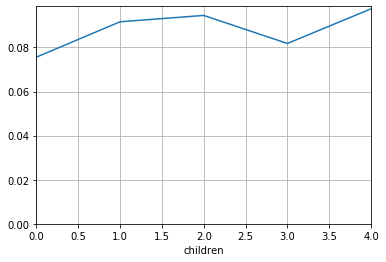

In [151]:
t['mean'].plot(ylim=0, grid=True)

**Вывод**

Судя по графику и таблице сверху, можно предположить, что у граждан без детей меньше просрочек по займам. Чем больше детей - тем больше просрочек.

- Есть ли зависимость между семейным положением и возвратом кредита в срок?

In [152]:
t = df.groupby('family_status')['debt'].agg(['count', 'mean'])

In [153]:
t.sort_values(by='mean')

,count,mean
family_status,,
вдовец / вдова,959,0.07
в разводе,1195,0.07
женат / замужем,12338,0.08
гражданский брак,4150,0.09
Не женат / не замужем,2810,0.10


**Вывод**

По таблице сверху видно, что меньше всего просрочек у вдов/вдовцов, в разводе. При этом больше всего просрочек у тех, кто не состоит/состоял в каких-либо отношениях. Скорее всего это также связано с возрастом.

In [154]:
t = df.groupby('family_status')[['debt', 'dob_years']].agg(['count', 'mean', 'median']).reset_index()

In [155]:
t.columns = ['_'.join(col).strip() for col in t.columns.values]

In [156]:
t.sort_values(by='debt_mean')

,family_status_,debt_count,debt_mean,debt_median,dob_years_count,dob_years_mean,dob_years_median
2,вдовец / вдова,959,0.07,0,959,57.04,58
1,в разводе,1195,0.07,0,1195,46.11,46
4,женат / замужем,12338,0.08,0,12338,43.94,43
3,гражданский брак,4150,0.09,0,4150,42.54,41
0,Не женат / не замужем,2810,0.10,0,2810,38.77,36


В этой таблице теперь наглядно видно, что на эти результаты также влиет и возраст. У не женатых/не замужем больше всего просрочек, но они и самые молодые. У вдов/вдовцов меньше всего просрочек, но они и самые старые в этой выборке.

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Для этого сначала построим сводную таблицу, а затем график.

In [157]:
t = df.groupby('total_income_group')['debt'].agg(['count','mean','sum'])

In [158]:
t

,count,mean,sum
total_income_group,,,
"(20666.999, 98535.2]",4291,0.08,344
"(98535.2, 130615.0]",4719,0.08,386
"(130615.0, 162161.0]",4234,0.09,370
"(162161.0, 214608.0]",3917,0.09,341
"(214608.0, 2265604.0]",4291,0.07,300


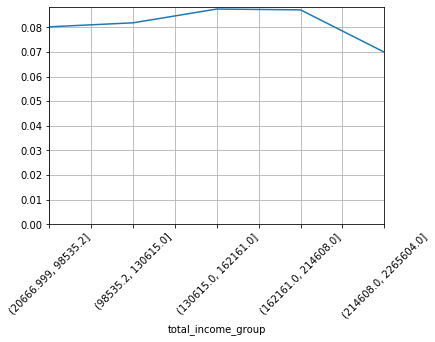

In [159]:
t['mean'].plot(ylim=0, grid=True, rot=45)

**Вывод**

Чем выше доход, тем меньше просрочек по кредитам.

- Как разные цели кредита влияют на его возврат в срок?

In [160]:
t = df.groupby('category_purpose')['debt'].agg(['count','mean','sum'])

In [161]:
t.sort_values(by='mean')

,count,mean,sum
category_purpose,,,
Недвижимость,10809,0.07,782
Свадьба,2324,0.08,186
Образование,4013,0.09,370
Автомобиль,4306,0.09,403


**Вывод**

Меньше всего просрочек у тех, кто берет деньги на операции, связанные с недвижимостью. Также возвращают те, кто берет деньги на свадьбу. Больше всего просрочек у тех, кто берет деньги на покупку автомобиля или образование.

## Шаг 4. Общий вывод

Ответив на вопросы, можно предположить, что чаще возвращают заемные деньги те, кто:
* Не имеет детей;
* Овдовел или в разводе;
* Имеет высокий уровень дохода;
* Берет кредит для проведения операций с недвижимостью.